# A Guide to the YREC Isochrone Suite
## By Vincent A. Smedile 
## The Ohio State University 

---
## ⚡ Installing Kiauhoku

Make sure the **Kiauhoku** package is installed. It can be found here:  
[Kiauhoku GitHub](https://github.com/zclaytor)  

Or install via Conda + pip:  
```bash
conda create -n stars numpy scipy pandas matplotlib requests pyarrow numba emcee
conda activate stars
pip install git+https://github.com/zclaytor/kiauhoku
```
Or 
```
pip install kiauhoku
```

---

## Import Functions and Tools

In [4]:
import kiauhoku as kh

---
make_iso() — Generate and Plot YREC Isochrones

The make_iso() function constructs YREC-style isochrones from a stellar model grid. It interpolates stellar parameters for a specified set of masses, metallicities ([Fe/H]), and ages, returning all computed parameters in a pandas.DataFrame. It can also plot any two chosen parameters.

Key Features:
- Returns all stellar parameters for each mass, age, and metallicity combination.
- Default columns for plotting:
- Teff: log_Teff (logarithm of effective temperature in K)
- Luminosity: LogL_lsun (logarithm of luminosity in solar units)
- Allows custom x/y plotting via plot_x and plot_y.
- Custom plotting must specify the column names in YREC (or chosen grid) you wish to use.
- Can save isochrones to CSV files.
- Handles multiple masses, ages, and metallicities at once.
- Optional progress bars and output clearing for Jupyter-friendly display.
---

In [ ]:
#make_iso() function
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

def make_iso(
    grid,
    mass_range=None,
    feh_range=None,
    age_range=None,
    feh=True,
    save_csv=False,
    plot_check=False,
    save_plot=False,
    outdir="./isochrones_output",
    verbose=True,
    clear_outputs=False,
    column_aliases="yrec",
    plot_x=None,
    plot_y=None
):
    """
    Construct YREC-style isochrones from a model grid.
    
    Returns all stellar parameters in a DataFrame, but allows
    plotting any two columns.

    Parameters
    ----------
    grid : object
        Grid object with .get_star_age((mass, Z), age) method.
    mass_range : tuple or array-like
        (start, stop, step) or list/array of masses.
    feh_range : tuple, float, or list
        (start, stop, step), float, or list of [Fe/H].
    age_range : tuple, float, or list
        (start, stop, step), float, or list of ages in Gyr.
    column_aliases : str or dict
        Default 'yrec' uses 'log_Teff' and 'LogL_lsun'.
    plot_x, plot_y : str, optional
        Names of columns to plot on x and y axes. Defaults to Teff/Lum if None.
    """

    # --- Check inputs ---
    if any(x is None for x in [mass_range, feh_range, age_range]):
        print("\n❗ Please specify valid mass_range, feh_range, and age_range.")
        print("   Example: mass_range=(0.7, 2.0, 0.05), feh_range=[0.0], age_range=[5.0]\n")
        return None

    # --- Column mapping ---
    if isinstance(column_aliases, str):
        if column_aliases.lower() == "yrec":
            colmap = {"teff": "log_Teff", "lum": "LogL_lsun"}
        else:
            raise ValueError("Unknown column_aliases string; use 'yrec' or a dict.")
    elif isinstance(column_aliases, dict):
        colmap = column_aliases
    else:
        raise ValueError("column_aliases must be 'yrec' or a dict mapping.")

    # --- If user specifies plot columns, override ---
    plot_x = plot_x or colmap["teff"]
    plot_y = plot_y or colmap["lum"]

    # --- Directory setup ---
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    # --- Range parsing ---
    def parse_range(r):
        if isinstance(r, tuple):
            return np.arange(r[0], r[1] + r[2] / 2, r[2])
        elif isinstance(r, (list, np.ndarray)):
            return np.array(r)
        else:
            return np.array([r])

    masses = parse_range(mass_range)
    fehs = parse_range(feh_range)
    ages = parse_range(age_range)

    # --- Isochrone computation ---
    records = []
    all_isos = []

    for feh_val in fehs:
        for age_val in ages:
            if feh:
                xnew, znew, zx = get_feh(feh_val)
            else:
                zx = feh_val

            iso_records = []
            desc = f"Isochrone: age={age_val:.2f} Gyr, [Fe/H]={feh_val:.2f}"
            iterator = tqdm(masses, desc=desc) if verbose else masses

            for mass in iterator:
                try:
                    star = grid.get_star_age((mass, zx, 1.7), age_val)
                    star_dict = star.to_dict()
                    star_dict.update({
                        "Mass_input": mass,
                        "Metallicity_input": feh_val,
                        "Z_used": zx,
                        "Age_input": age_val
                    })
                    iso_records.append(star_dict)
                    records.append(star_dict)
                except Exception:
                    continue

            df_iso = pd.DataFrame(iso_records)
            all_isos.append((feh_val, age_val, df_iso))

            if verbose:
                print(f"Computed isochrone for age={age_val:.2f} Gyr, [Fe/H]={feh_val:.2f}: {len(df_iso)} stars")

            if save_csv and len(df_iso) > 0:
                csv_path = outdir / f"iso_age{age_val:.2f}_feh{feh_val:.2f}.csv"
                df_iso.to_csv(csv_path, index=False)

            if clear_outputs:
                clear_output(wait=True)

    # --- Check if anything succeeded ---
    if len(records) == 0:
        print("\n No isochrone points were computed — likely no grid coverage for given Fe/H or age.")
        return None

    # --- Plotting ---
    if plot_check:
        ages_unique = sorted(set(a for _, a, _ in all_isos))
        n_ages = len(ages_unique)
        ncols = min(3, n_ages)
        nrows = int(np.ceil(n_ages / ncols))
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
        axes = np.array(axes).reshape(-1)
        cmap = plt.cm.plasma

        for i, age_val in enumerate(ages_unique):
            ax = axes[i]
            iso_for_age = [(f, a, d) for f, a, d in all_isos if a == age_val and len(d) > 0]
            if not iso_for_age:
                continue
            fehs_plot = [f for f, _, _ in iso_for_age]
            norm = plt.Normalize(min(fehs_plot), max(fehs_plot)) if len(set(fehs_plot)) > 1 else None

            for f, a, df in iso_for_age:
                color = cmap(norm(f)) if norm else "black"
                ax.plot(df[plot_x], df[plot_y], color=color, label=f"[Fe/H]={f:.2f}")

            ax.set_xlabel(plot_x)
            ax.set_ylabel(plot_y)
            ax.set_title(f"Age = {age_val:.2f} Gyr")
            if norm:
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                fig.colorbar(sm, ax=ax, label="[Fe/H]")

        plt.tight_layout()
        if save_plot:
            plt.savefig(outdir / "isochrone_grid_plot.png", bbox_inches="tight")
        plt.show()

    return pd.DataFrame(records)


---
Below is the Fe/H conversion function, which converts Z and X (the native track metals and hydrogen abundance) to more commonly used Fe/H. The default Zsun, ZXsun, and Xsun are the Grevesse & Sauval 1998 abundances, but this can be changed according to mixture.

---

In [7]:
#Z/X to Fe/H Converter
def get_feh(feh, zsun = 0.0248, zxsun=0.022917651, xsun = 1.88970000e-02):
    zx = (zxsun)*(10**(feh))
    xnew = (1-zsun)/(1+(1+zsun/xsun)*zx)
    znew = zx * xnew
    return xnew, znew, zx

---
## Making Isochrones

### Isochrones With A Pre-Packaged Grid

#### **Example 1:** If the grid is already prepared, one can use the code below to access the grid, generate a set of isochrones using points at a specified metallicity and age, with stellar masses as specified.

In [5]:
# First we import the grid we want from Kiauhoku, the grid is a .pkl file found in the GitHub
# It must be the file labeled interpolator
gridpath = '/Users/vincentsmedile/.kiauhoku/grids/YREC_release_grid/interpolator.pkl' # change according to where you put this anywhere is fine but use full path
mygrid = kh.load_interpolator(path=gridpath)

Isochrone: age=0.15 Gyr, [Fe/H]=-0.03: 100%|█| 1501/1501 [00:05<00:00, 264.31it/

Computed isochrone for age=0.15 Gyr, [Fe/H]=-0.03: 1501 stars


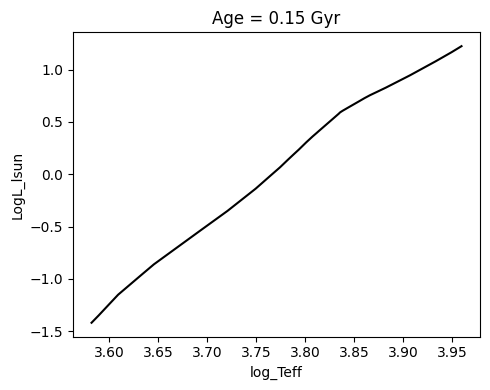

In [13]:
# Generating a Single Isochrone for a specific target: The Pleiades
outdir='/Users/vincentsmedile/YREC5.1/models/isochrones'
pliso = make_iso(
    mygrid,
    mass_range=(0.5, 2.0, 0.001),
    feh_range=[-0.03],
    age_range=[0.150],
    save_csv=False,
    outdir=outdir, 
    plot_check=True,
    plot_x="log_Teff", #make sure to use the names from the .track file columns
    plot_y="LogL_lsun"   
)


#### **Exmaple 2:** One can use a similar framework to generate and plot a grid of isochrones at a range of ages and masses

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
Isochrone: age=1.00 Gyr, [Fe/H]=0.00: 100%|█| 2001/2001 [00:07<00:00, 282.98it/s


Computed isochrone for age=1.00 Gyr, [Fe/H]=0.00: 1142 stars


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
Isochrone: age=2.00 Gyr, [Fe/H]=0.00: 100%|█| 2001/2001 [00:07<00:00, 272.45it/s


Computed isochrone for age=2.00 Gyr, [Fe/H]=0.00: 681 stars


Isochrone: age=3.00 Gyr, [Fe/H]=0.00: 100%|█| 2001/2001 [00:07<00:00, 268.94it/s


Computed isochrone for age=3.00 Gyr, [Fe/H]=0.00: 479 stars


Isochrone: age=4.00 Gyr, [Fe/H]=0.00: 100%|█| 2001/2001 [00:07<00:00, 270.17it/s


Computed isochrone for age=4.00 Gyr, [Fe/H]=0.00: 384 stars


Isochrone: age=5.00 Gyr, [Fe/H]=0.00: 100%|█| 2001/2001 [00:07<00:00, 270.27it/s


Computed isochrone for age=5.00 Gyr, [Fe/H]=0.00: 298 stars


Isochrone: age=6.00 Gyr, [Fe/H]=0.00: 100%|█| 2001/2001 [00:07<00:00, 266.01it/s


Computed isochrone for age=6.00 Gyr, [Fe/H]=0.00: 236 stars


Isochrone: age=7.00 Gyr, [Fe/H]=0.00: 100%|█| 2001/2001 [00:07<00:00, 260.66it/s


Computed isochrone for age=7.00 Gyr, [Fe/H]=0.00: 182 stars


Isochrone: age=8.00 Gyr, [Fe/H]=0.00: 100%|█| 2001/2001 [00:07<00:00, 270.74it/s


Computed isochrone for age=8.00 Gyr, [Fe/H]=0.00: 139 stars


Isochrone: age=9.00 Gyr, [Fe/H]=0.00: 100%|█| 2001/2001 [00:07<00:00, 271.91it/s


Computed isochrone for age=9.00 Gyr, [Fe/H]=0.00: 97 stars


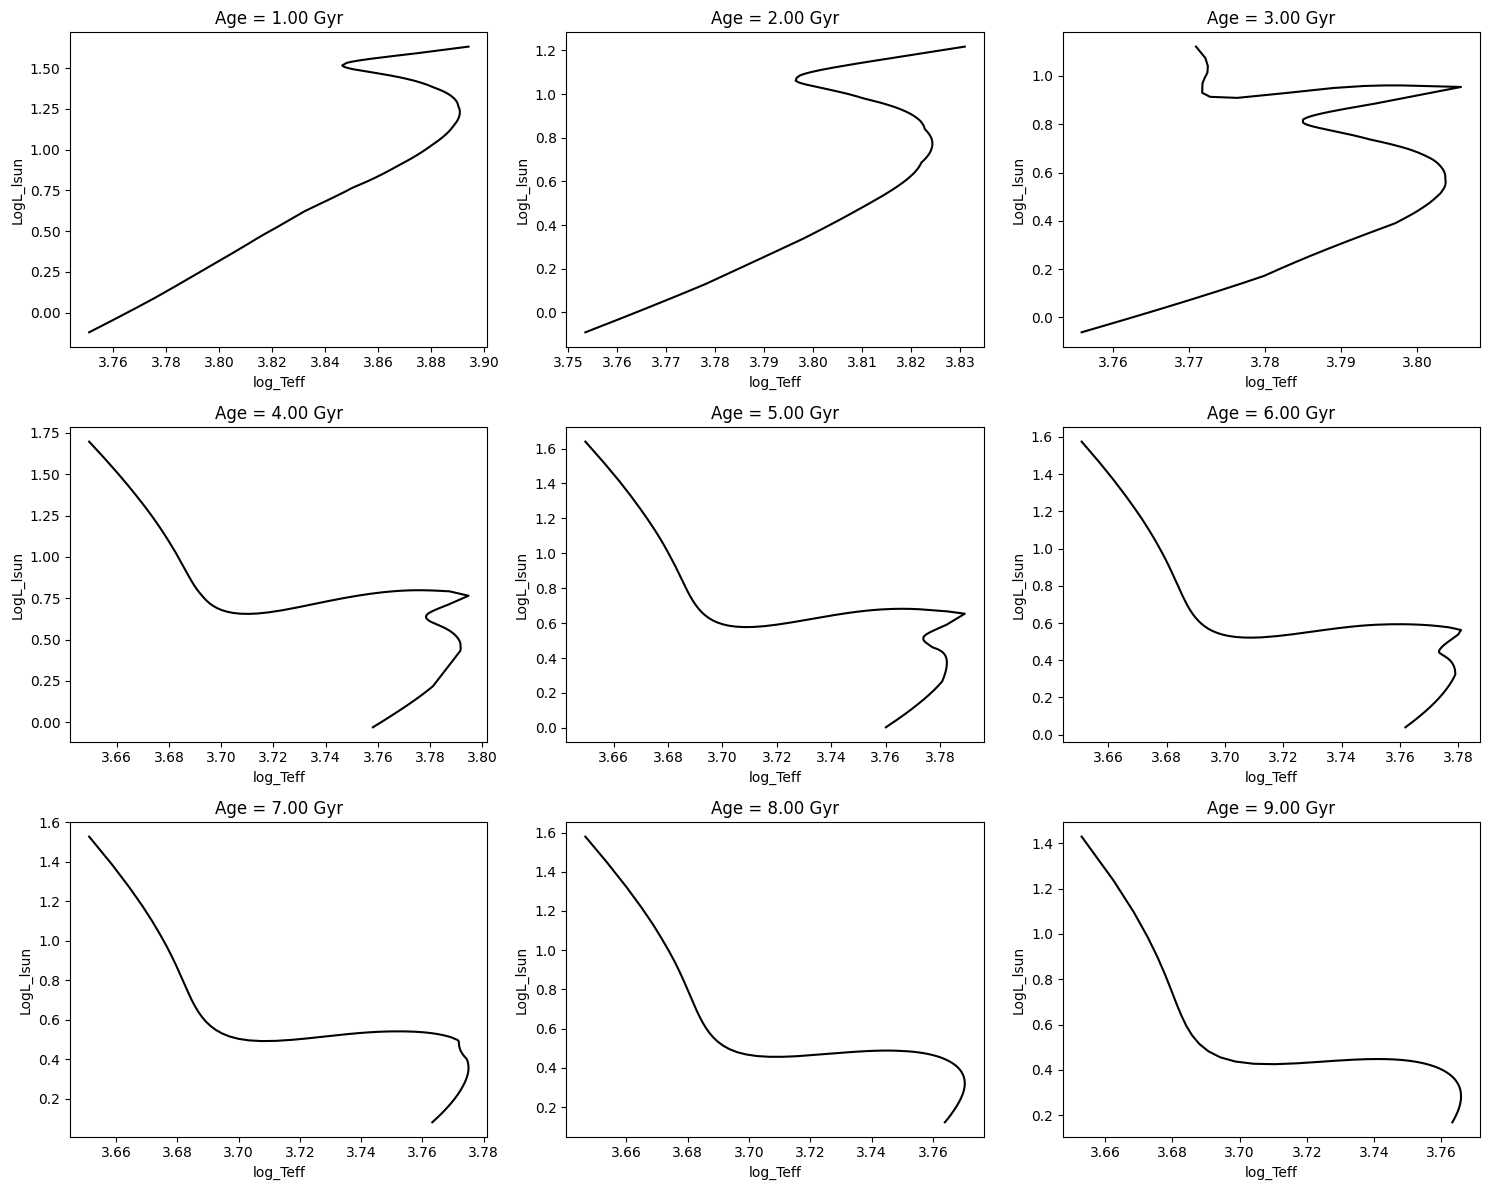

In [11]:
outdir='/Users/vincentsmedile/YREC5.1/models/isochrones'
df_iso = make_iso(
    grid=mygrid,
    mass_range=(1.0, 3.0, 0.001),
    feh_range=[0.0],        # ✅ list instead of (0.0)
    age_range=(1.0, 9.0, 1),
    save_csv=False,
    verbose=True,
    clear_outputs=False,
    outdir=outdir, 
    plot_check=True,
    plot_x="log_Teff",
    plot_y="LogL_lsun" 
)


### Custom Install of A Different YREC Grid

---
**If one has recently generated a new grid of models it is possible to use the code below here to format them for ingestion into kiauhoku, and prepare them to create isochrones as described before.** 

**To perform the previous exercieses with a custom grid, one must create a summed hydrogen luminosity column (for the identification of correct Equivalent Evolutionary Points- EEPs), and edit the install file, and then install the new grid into Kiauhoku**

---
## 🪐 Installing a Custom YREC Grid

1. **Edit filepaths** in `custom_install_yrec.py` to point to your `.track` files.

2. **Update the EEP dictionary** names if you changed the track headers.

3. **Create the Hydrogen Luminosity column** by running:

   ```python
   append_H_lum(track_directory, output_directory)
   ```

4. **Ensure `column_labels.txt`** (a list of column names, one per line) is in your track directory.

5. **Install the grid** from your notebook (with `custom_install_yrec.py` in the same directory):

   ```python
   kh.install_grid('custom_install_yrec')
   ```

6. **Use the installed grid path** shown in the output — the file ending in **`interpolator.pkl`**.

   Example output:

   ```
   Saving to ~/.kiauhoku/grids/YREC_release_grid/interpolator.pkl
   Model grid "YREC_release_grid" installed.
   ```

---


Below is the append_H_lum() function, which finds all the .track files and then combines the necessary columns to make the Hydrogen Luminosity column (H_lum), while still preserving the native .track file format.

In [23]:
## Append H Lum Function
from pathlib import Path

def append_H_lum(track_dir, output_dir=None):
    track_dir = Path(track_dir)
    if output_dir is None:
        output_dir = track_dir
    else:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

    for file in sorted(track_dir.glob("*.track")):
        print(f"Processing {file.name} ...")
        lines = file.read_text().splitlines()
        new_lines = []

        # Find last header line
        last_hash_idx = max(i for i, l in enumerate(lines) if l.strip().startswith("#"))
        header_line_idx = last_hash_idx - 1
        header = lines[header_line_idx].replace("#", "").split()
        
        # Append H_lum to header
        new_header_line = lines[header_line_idx].rstrip() + " H_lum"
        new_lines.extend(lines[:header_line_idx])
        new_lines.append(new_header_line)
        new_lines.append(lines[last_hash_idx])

        # Process data lines
        for line in lines[last_hash_idx + 1:]:
            if line.strip() == "":
                new_lines.append(line)
                continue
            vals = line.split()
            # get indices of the ppI/II/III/CNO columns
            try:
                ppI = float(vals[header.index("ppI_lsun")])
                ppII = float(vals[header.index("ppII_lsun")])
                ppIII = float(vals[header.index("ppIII_lsun")])
                CNO = float(vals[header.index("CNO_lsun")])
            except ValueError:
                new_lines.append(line)
                continue
            H_lum = ppI + ppII + ppIII + CNO
            new_line = line.rstrip() + f" {H_lum:.6e}"
            new_lines.append(new_line)

        # Write to file
        out_file = output_dir / file.name
        out_file.write_text("\n".join(new_lines) + "\n")
        print(f"✅ Saved {out_file.name}")


In [5]:
gridpath = '/Users/vincentsmedile/YREC5.1/models/grid3_tracks'
outpath = '/Users/vincentsmedile/YREC5.1/models/yrec_sample_grid'
append_H_lum(track_dir = gridpath, output_dir=outpath)

Processing m0300fehm000_Grid_base_ZAHB.track ...
✅ Saved m0300fehm000_Grid_base_ZAHB.track
Processing m0300fehm050_Grid_base_ZAHB.track ...
✅ Saved m0300fehm050_Grid_base_ZAHB.track
Processing m0300fehm100_Grid_base_ZAHB.track ...
✅ Saved m0300fehm100_Grid_base_ZAHB.track
Processing m0300fehp050_Grid_base_ZAHB.track ...
✅ Saved m0300fehp050_Grid_base_ZAHB.track
Processing m0400fehm000_Grid_base_ZAHB.track ...
✅ Saved m0400fehm000_Grid_base_ZAHB.track
Processing m0400fehm050_Grid_base_ZAHB.track ...
✅ Saved m0400fehm050_Grid_base_ZAHB.track
Processing m0400fehm100_Grid_base_ZAHB.track ...
✅ Saved m0400fehm100_Grid_base_ZAHB.track
Processing m0400fehp050_Grid_base_ZAHB.track ...
✅ Saved m0400fehp050_Grid_base_ZAHB.track
Processing m0500fehm000_Grid_base_ZAHB.track ...
✅ Saved m0500fehm000_Grid_base_ZAHB.track
Processing m0500fehm050_Grid_base_ZAHB.track ...
✅ Saved m0500fehm050_Grid_base_ZAHB.track
Processing m0500fehm100_Grid_base_ZAHB.track ...
✅ Saved m0500fehm100_Grid_base_ZAHB.track

In [6]:
kh.install_grid('custom_install_yrec')

Installing grid "YREC_grids_sample" from custom_install_yrec
Reading and combining grid files


  0%|                                                   | 0/312 [00:00<?, ?it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5100fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6600fehp050_Grid_base.track


  1%|▍                                          | 3/312 [00:00<00:12, 25.21it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0800fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3500fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4900fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4400fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1000fehm000_Grid_base.track


  3%|█▎                                        | 10/312 [00:00<00:11, 26.67it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2700fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7300fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6200fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5500fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6800fehm100_Grid_base.track


  4%|█▊                                        | 13/312 [00:00<00:12, 24.52it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3100fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0600fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7700fehm050_Grid_base.track


  5%|██▏                                       | 16/312 [00:00<00:12, 23.93it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2300fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1400fehm000_Grid_base.track


  6%|██▋                                       | 20/312 [00:00<00:11, 24.95it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4000fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1900fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5300fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6400fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3700fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5900fehp050_Grid_base.track


  9%|███▊                                      | 28/312 [00:01<00:09, 29.24it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1800fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4100fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1500fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2200fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7600fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3900fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m8000fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6000fehm100_Grid_base.track


 10%|████▏                                     | 31/312 [00:01<00:10, 27.46it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5700fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3300fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0400fehp050_Grid_base.track


 11%|████▌                                     | 34/312 [00:01<00:10, 26.75it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7200fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2600fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1100fehm050_Grid_base.track


 12%|████▉                                     | 37/312 [00:01<00:09, 27.53it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4500fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4800fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3500fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6100fehm050_Grid_base.track


 13%|█████▌                                    | 41/312 [00:01<00:09, 29.95it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5600fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3800fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7400fehp050_Grid_base.track


 14%|██████                                    | 45/312 [00:01<00:08, 30.64it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4300fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4900fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2700fehm100_Grid_base.track


 16%|██████▌                                   | 49/312 [00:01<00:09, 28.37it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1000fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6800fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0600fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5200fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6500fehm050_Grid_base.track


 17%|███████                                   | 52/312 [00:01<00:10, 25.24it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3100fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4700fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7000fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2900fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1400fehm100_Grid_base.track


 18%|███████▋                                  | 57/312 [00:02<00:08, 29.65it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2300fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3000fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6400fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5300fehm000_Grid_base.track


 20%|████████▎                                 | 62/312 [00:02<00:08, 30.95it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0700fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6900fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1800fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7600fehm100_Grid_base.track


 21%|████████▉                                 | 66/312 [00:02<00:09, 26.62it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4100fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2500fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1200fehp050_Grid_base.track


 22%|█████████▍                                | 70/312 [00:02<00:08, 28.56it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3900fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0300fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5700fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6000fehm000_Grid_base.track


 24%|█████████▉                                | 74/312 [00:02<00:08, 28.83it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3400fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4500fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7200fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1600fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2100fehp050_Grid_base.track


 26%|███████████                               | 82/312 [00:02<00:07, 31.44it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7800fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1500fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2200fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4600fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7100fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2800fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6900fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0700fehm000_Grid_base.track


 28%|███████████▌                              | 86/312 [00:03<00:07, 29.51it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5300fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6400fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3000fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4800fehm100_Grid_base.track


 29%|████████████                              | 90/312 [00:03<00:07, 30.45it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2600fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1100fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7500fehp050_Grid_base.track


 30%|████████████▊                             | 95/312 [00:03<00:06, 32.08it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4200fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3400fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6000fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5700fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0300fehm000_Grid_base.track


 32%|█████████████▎                            | 99/312 [00:03<00:06, 32.11it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3900fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1700fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2000fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7900fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4400fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7300fehm100_Grid_base.track


 33%|█████████████▌                           | 103/312 [00:03<00:07, 28.73it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3800fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5600fehm000_Grid_base.track


 34%|██████████████                           | 107/312 [00:03<00:06, 30.46it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6100fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3500fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2400fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1300fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1900fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7700fehm100_Grid_base.track


 37%|██████████████▉                          | 114/312 [00:04<00:06, 28.43it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4000fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3100fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6500fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5200fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0600fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6800fehm050_Grid_base.track


 38%|███████████████▊                         | 120/312 [00:04<00:07, 26.08it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7600fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2200fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1500fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4100fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1800fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6900fehm100_Grid_base.track


 41%|████████████████▋                        | 127/312 [00:04<00:06, 28.62it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3000fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0700fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6300fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5400fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4800fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4500fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1100fehm000_Grid_base.track


 43%|█████████████████▍                       | 133/312 [00:04<00:06, 28.64it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2600fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7200fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0300fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3400fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5000fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6700fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0900fehp050_Grid_base.track


 45%|██████████████████▌                      | 141/312 [00:04<00:05, 31.49it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7300fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2700fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1000fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4400fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4900fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3200fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0500fehp050_Grid_base.track


 48%|███████████████████▌                     | 149/312 [00:05<00:05, 29.33it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3800fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6100fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5600fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1900fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4000fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1400fehm050_Grid_base.track


 49%|████████████████████                     | 153/312 [00:05<00:05, 31.57it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2300fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7700fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3600fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5800fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5200fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6500fehm100_Grid_base.track


 52%|█████████████████████▏                   | 161/312 [00:05<00:05, 29.32it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m8000fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3300fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6700fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5000fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0400fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0900fehm000_Grid_base.track


 53%|█████████████████████▋                   | 165/312 [00:05<00:05, 28.94it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4800fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2600fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1100fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7500fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4200fehm100_Grid_base.track


 54%|██████████████████████▏                  | 169/312 [00:05<00:05, 24.92it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5900fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5400fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6300fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3700fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1500fehp050_Grid_base.track


 56%|██████████████████████▉                  | 175/312 [00:06<00:05, 23.08it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2200fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4600fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7100fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2800fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3600fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6200fehm050_Grid_base.track


 59%|████████████████████████▏                | 184/312 [00:06<00:04, 29.12it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5500fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5800fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2400fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1300fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1900fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7700fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4000fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0800fehm050_Grid_base.track


 60%|████████████████████████▋                | 188/312 [00:06<00:04, 28.20it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0500fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5100fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6600fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3200fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1700fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2000fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7900fehm100_Grid_base.track


 63%|█████████████████████████▊               | 196/312 [00:06<00:04, 28.35it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4400fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7300fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0300fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3400fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5000fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6700fehm100_Grid_base.track


 65%|██████████████████████████▌              | 202/312 [00:07<00:04, 25.68it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0900fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7800fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4200fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1600fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2100fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7500fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6900fehp050_Grid_base.track


 67%|███████████████████████████▍             | 209/312 [00:07<00:03, 26.21it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3000fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0700fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6300fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5400fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7100fehm000_Grid_base.track


 69%|████████████████████████████▍            | 216/312 [00:07<00:03, 28.71it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2500fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1200fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4600fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2800fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3600fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5800fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5200fehp050_Grid_base.track


 71%|█████████████████████████████▎           | 223/312 [00:07<00:03, 29.58it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6500fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2900fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4700fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1300fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2400fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7000fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3200fehm100_Grid_base.track


 74%|██████████████████████████████▏          | 230/312 [00:08<00:02, 29.55it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0500fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3800fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6100fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5600fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7400fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2000fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1700fehm000_Grid_base.track


 76%|███████████████████████████████▎         | 238/312 [00:08<00:02, 32.27it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4300fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7900fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7000fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2400fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1300fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4700fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2900fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6200fehm100_Grid_base.track


 78%|███████████████████████████████▊         | 242/312 [00:08<00:02, 28.83it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5500fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6800fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3100fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0600fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7900fehm050_Grid_base.track


 80%|████████████████████████████████▊        | 250/312 [00:08<00:02, 29.49it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4300fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1700fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2000fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7400fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5100fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6600fehm100_Grid_base.track


 82%|█████████████████████████████████▋       | 256/312 [00:09<00:02, 27.08it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0800fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3500fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7500fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2100fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1600fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4200fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7800fehm000_Grid_base.track


 85%|██████████████████████████████████▋      | 264/312 [00:09<00:01, 29.37it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3900fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m8000fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6000fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5700fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3300fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0400fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2800fehm050_Grid_base.track


 86%|███████████████████████████████████▏     | 268/312 [00:09<00:01, 30.83it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4600fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1200fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2500fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7100fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5300fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6400fehp050_Grid_base.track


 87%|███████████████████████████████████▋     | 272/312 [00:09<00:01, 29.14it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3700fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5900fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4700fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7000fehm100_Grid_base.track


 89%|████████████████████████████████████▋    | 279/312 [00:09<00:01, 25.42it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2900fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1400fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2300fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5800fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5500fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6200fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3600fehm050_Grid_base.track


 91%|█████████████████████████████████████▏   | 283/312 [00:10<00:01, 25.02it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7400fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4300fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4900fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2700fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1000fehp050_Grid_base.track


 93%|██████████████████████████████████████▏  | 291/312 [00:10<00:00, 27.65it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3200fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6600fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5100fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0500fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0800fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4500fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7200fehp050_Grid_base.track


 96%|███████████████████████████████████████▎ | 299/312 [00:10<00:00, 28.06it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1600fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2100fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7800fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m8000fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0900fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m0400fehm000_Grid_base.track


 99%|████████████████████████████████████████▍| 308/312 [00:10<00:00, 33.76it/s]

/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5000fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6700fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3300fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1800fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m7600fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m4100fehp050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m2500fehm100_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m1200fehm100_Grid_base.track


100%|█████████████████████████████████████████| 312/312 [00:11<00:00, 28.27it/s]


/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m3700fehm000_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m6300fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5400fehm050_Grid_base.track
/Users/vincentsmedile/YREC5.1/models/yrec_final_grid2/m5900fehm000_Grid_base.track
Saving to /Users/vincentsmedile/.kiauhoku/grids/YREC_grids_sample/full_grid.pqt
Converting to eep-based tracks


  0%|          | 0/312 [00:00<?, ?it/s]

Saving to /Users/vincentsmedile/.kiauhoku/grids/YREC_grids_sample/eep_grid.pqt
Saving interpolator to /Users/vincentsmedile/.kiauhoku/grids/YREC_grids_sample/interpolator.pkl
Model grid "YREC_grids_sample" installed.


In [8]:
# Then install the grid the normal way 
gridpath = '/Users/vincentsmedile/.kiauhoku/grids/YREC_grids_sample/interpolator.pkl'
mygrid = kh.load_interpolator(path=gridpath)
# And then use the steps in the previous lines to make isochrones!